# Adversarial Search: Playing Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state

In [1]:
# Your code/answer goes here.
#Defined below in HeloperFunctions class

How big is the state space? Give an estimate and explain it.

A rough state space estimate is 3^42 because each cell could theoretically be a 0, a 1 or a -1. 

How big is the game tree that minimax search will go through? Give an estimate and explain it.

The game tree was roughly 7^42 because there are 42 possible moves to make in a game and each move can spawn 7 counter moves from it.

## Task 2: Game Environment and Random Agent [2 point]

Use a numpy character array as the board.

In [2]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player whose next move it is and who the agent should play.

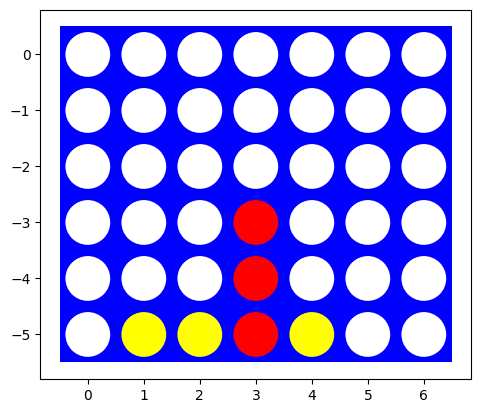

In [3]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [4]:
# Your code/ answer goes here.
from scipy.signal import convolve2d
from timeit import default_timer as timer
import math
class HelperFunctions:
    @staticmethod
    def place(choice:int, board,player:int=None):
        # print(board)
        theBoard = np.array(board).transpose()
        if player is None:
            arr_sum = theBoard.sum()
            if(arr_sum <= 0): player = 1
            else: player = -1
        # print(theBoard)
        lst = theBoard[choice]
        gen = (len(lst) - 1 - i for i, v in enumerate(reversed(lst)) if v == 0)
        last_idx = next(gen, None)
        theBoard[choice][last_idx] = player
        return theBoard.transpose()
    @staticmethod
    def get_valid_moves(board):
        return [i for i,j in enumerate(board[0]) if j == 0]

    @staticmethod
    def to_move(board):
        theBoard = np.array(board)
        arr_sum = theBoard.sum()
        if(arr_sum <= 0): player = 1
        else: player = -1
        return player
    @staticmethod
    def check_win(board):
        if(len(HelperFunctions.get_valid_moves(board)) == 0): return None
        horizontal_kernel = np.array([[ 1, 1, 1, 1]])
        vertical_kernel = np.transpose(horizontal_kernel)
        diag1_kernel = np.eye(4, dtype=np.uint8)
        diag2_kernel = np.fliplr(diag1_kernel)
        detection_kernels = [horizontal_kernel, vertical_kernel, diag1_kernel, diag2_kernel]
        for kernel in detection_kernels:

            a = convolve2d(board,kernel,mode='valid')
            if( (a == 4).any()):
                return 1
            if ((a == -4).any()):
                return -1
            
            # print(a.any())
        return 0
    @staticmethod
    def evaluate_board(board,player):
        try:
            return HelperFunctions.calc_utility(player,board) * 2,True
        except:
            horizontal_kernel = np.array([[ 1, 1, 1, 1]])
            vertical_kernel = np.transpose(horizontal_kernel)
            diag1_kernel = np.eye(4, dtype=np.uint8)
            diag2_kernel = np.fliplr(diag1_kernel)
            detection_kernels = [horizontal_kernel, vertical_kernel, diag1_kernel, diag2_kernel]
            utils = []
            for kernel in detection_kernels:
                # print(kernel)
                a = convolve2d(board,kernel,mode='valid')
                if(a == (3 * player)).any():
                    # utils.append(0.5)
                    times = np.count_nonzero(a == (3 * player))
                    utils += [0.5] * times
                if(a == (2 * player)).any():
                    # utils.append(0.25)
                    times = np.count_nonzero(a == (2 * player))
                    utils += [0.25] * times
                if(a == (3 * player) * -1).any():
                    # utils.append(-0.5)
                    times = np.count_nonzero(a == (3 * player * -1))
                    utils += [-0.5] * times
                if(a == (2 * player) * -1).any():
                    # utils.append(-0.25)
                    times = np.count_nonzero(a == (2 * player * -1))
                    utils += [-0.25] * times
            seven_trap = np.array([
                [1,1,1],
                [0,1,0],
                [1,0,0]
            ])
            seven_kernels = [seven_trap]
            seven_kernels.append(np.array([
                [1,1,1],
                [0,1,0],
                [0,0,1]
            ]))
            seven_kernels = [np.flip(arr) for arr in seven_kernels]
            for kernel in seven_kernels:
                a = convolve2d(board,kernel,mode='valid')
                if(a == (5 * player)).any():
                    times = np.count_nonzero(a == (5 * player))
                    utils += [0.75] * times
                if(a == (5 * player * -1)).any():
                    times = np.count_nonzero(a == (5 * player * -1))
                    utils += [-0.75] * times
                    
                    # print('7 trap found')
                # print(a)

            #TODO Add Zigzag trap
            
            if len(utils) != 0:
                # print(f"Sum of utils: {np.sum(utils)}")
                return HelperFunctions.sigmoid(np.sum(utils)),False
            else: return 0,False
    @staticmethod
    def time_function(theFunc,*args):
        start = timer()
        theFunc(*args)
        print(f"{theFunc.__name__}: {(timer() - start) * 1000} ms")
    @staticmethod
    def calc_utility(player,board):
        winner  = HelperFunctions.check_win(board)
        # print("Winner is ",winner)
        if len(HelperFunctions.get_valid_moves(board)) == 0:
            return 0
        if winner == 0: raise Exception("Tried to calculate the utility of non-terminal State")
        if winner == player: return 1
        else: return -1
    @staticmethod
    def sigmoid(x):
        return((1 / (1 + math.e**-x)) * 2) -1
        
# board = [[0, 0, 0, 0, 0, 0, 0],
#          [0, 0, 0, 0, 0, 0, 0],
#          [0, 0, 0, 0, 0, 0, 0],
#          [0, 0, 0, 1, 0, 0, 0],
#          [0, 0, 1, 1, 0, 0, 0],
#          [0, 1, 0, 1, 0, 0, 0]]


# board = [
#     [-1,  0, -1, -1,  0,  0,  0],
#     [ 1,  0, -1,  1,  0,  0,  0,],
#     [ 1,  0, -1, -1,  1,  0,  0,],
#     [ 1,  0,  1,  1, -1,  0,  0],
#     [-1,  0, -1,  1,  1, 0,  0],
#     [-1,  1,  1,  1, -1,  0,  0]

# ]

# visualize(board)
# print(HelperFunctions.evaluate_board(board,-1))



# kernel = np.array([
#     [1,1,1],
#     [0,1,0],
#     [1,0,0]
# ])
# kernel = np.flip(kernel)


# print(np.array(board))
# a = convolve2d(board,kernel,mode='valid')
# print(a)
# print(HelperFunctions.sigmoid(-3))

# print(HelperFunctions.calc_utility(1,board))

# print(HelperFunctions.to_move(board))
# visualize(board)

# HelperFunctions.time_function(HelperFunctions.check_win,board)


Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what side they are playing. The value passed on bt yhe environment should be 1 ot -1 for playerred and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [5]:
# Your code/ answer goes here.
import random
def random_player(board,player= None):
    try:
        return {"move":random.choice(HelperFunctions.get_valid_moves(board)),"value":0}
    except:
        return None

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [6]:
# Your code/ answer goes here.
def random_agents_environment(num_iters=1000):
    players = [1,-1]
    attempts = []
    for i in range(num_iters):
        board = empty_board()
        turn_num = 0
        while(HelperFunctions.check_win(board) == 0):
            print("Player",players[turn_num % len(players)],"Util for him:",HelperFunctions.evaluate_board(board,players[turn_num % len(players)]))
            # visualize(board)
            the_choice = random_player(board)
            if(the_choice is None): break
            else: the_choice = the_choice['move']
            turn = players[turn_num % len(players)]
            board = HelperFunctions.place(the_choice,board,player=turn)
            turn_num += 1
        # visualize(board)
        attempts.append({
            "turns_taken":turn_num,
            "winner":HelperFunctions.check_win(board)
        })
    return attempts
def print_results(attempts):
    p1_wins = len([val for val in attempts if val["winner"] == 1])
    p2_wins = len([val for val in attempts if val["winner"] == -1])
    ties = len([val for val in attempts if val["winner"] is None])
    turns = np.array([val["turns_taken"] for val in attempts]).mean()
    print(f'''
    Player 1 Wins: {p1_wins}
    Player 2 Wins: {p2_wins}
    Ties: {ties}
    Average Turns: {turns}''')
    
    


attempts = random_agents_environment(num_iters=1)
# print_results(attempts)
# print(attempts)

Player 1 Util for him: (0, False)
Player -1 Util for him: (0, False)
Player 1 Util for him: (0, False)
Player -1 Util for him: (-0.12435300177159614, False)
Player 1 Util for him: (0.0, False)
Player -1 Util for him: (-0.2449186624037092, False)
Player 1 Util for him: (-0.2449186624037092, False)
Player -1 Util for him: (0.12435300177159614, False)
Player 1 Util for him: (-0.35835739835078595, False)
Player -1 Util for him: (0.12435300177159614, False)
Player 1 Util for him: (-0.5545997223493824, False)
Player -1 Util for him: (0.35835739835078595, False)


## Task 3: Minimax Search with Alpha-Beta Pruning [4 points]

### Implement the search starting.

Implement the search starting from a given board and specifying the player and put it into an agent function.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

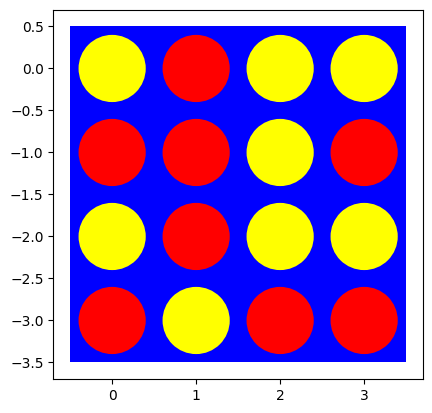

In [7]:
# Your code/ answer goes here.
import sys

ITERATIONS = 0
DEBUG = False
def min_value(board,player,alpha,beta):
    global ITERATIONS
    global DEBUG
    ITERATIONS+=1
    # if DEBUG:
    #     print(f"IN MIN VALUE | Alpha: {alpha}, Beta: {beta}")
    # visualize(board)
    # print(f"In min iteration #{ITERATIONS}")
    # print(f"Calculating min value for {player} with board\n{board}\nIteration #{curr_iters}")
    try:
        return HelperFunctions.calc_utility(player,board),None
    except:
        v = float('inf')
        for action in HelperFunctions.get_valid_moves(board):
            v2,a2 = max_value(HelperFunctions.place(action,board),player,alpha,beta)
            if(v2 < v):
                v = v2
                move = action
                beta = min([beta,v])
            if v <= alpha:
                if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
                return v,move
        return v,move
def max_value(board,player,alpha,beta):
    global ITERATIONS
    # visualize(board)
    ITERATIONS+=1
    global DEBUG
    # if DEBUG:
    #     print(f"IN MAX VALUE | Alpha: {alpha}, Beta: {beta}")
    # print(f"In max iteration #{ITERATIONS}")
    # print(f"Calculating max value for {player} with board\n{board}\nIteration #{curr_iters}")
    try:
        return HelperFunctions.calc_utility(player,board),None
    except:
        v = float('-inf')
        for action in HelperFunctions.get_valid_moves(board):
            v2,a2 = min_value(HelperFunctions.place(action,board),player,alpha,beta)
            if v2 > v:
                v = v2
                move = action
                alpha = max([alpha,v])
            if v >= beta: 
                if DEBUG >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
                return v,move
                
        return v,move
def minimax_search(board,player=None):
    global ITERATIONS
    ITERATIONS = 0
    curr_iters = 0
    if player is None:
        player = HelperFunctions.to_move(board)
    board = np.array(board)
    if(np.count_nonzero(board == player,axis=None) < 2):
        return {"move":random.choice(HelperFunctions.get_valid_moves(board)),"value":0}
    value,move = max_value(board,player,alpha=float('-inf'),beta=float('inf'))
    # print(player)
    color = "Red"
    if player == -1: color = "Yellow"
    global DEBUG
    if DEBUG: print(f"Player: {color} | value: {value} | move:{move}")
    return {"move":move,"value":value}
    
def minimax_env(board=None,verbose=False):
    if board is None:
        board = empty_board(shape=(4,4))
    global DEBUG
    DEBUG = verbose
    while(HelperFunctions.check_win(board) == 0):
        board = HelperFunctions.place(minimax_search(board)["move"],board)
        if DEBUG: 
            visualize(board)
            
    visualize(board)
        
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, -1, 0, 0, 0],
         [0, 0, 0, -1, 0, 0, 0],
         [0, 0, 0, -1, 0, 0, 0],
         [0, 0, 0, 1, 0, 1, 1]]

_board2 = [[1,-1,1,-1],
          [-1,1,1,1],
          [-1,1,-1,1],
          [-1,-1,-1,1]]
# visualize(_board2)
# print(HelperFunctions.calc_utility(-1,_board2))

# print(theBoard)
# visualize(_board)
# print(minimax_search(_board2))
_board = np.array(board)


minimax_env(empty_board(shape=(4,4)),verbose=False)

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

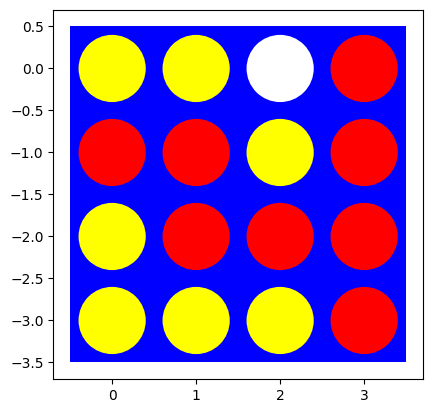

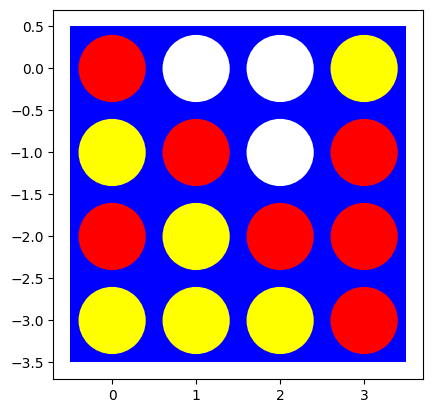

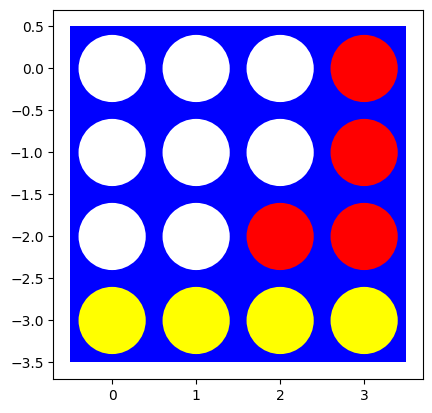

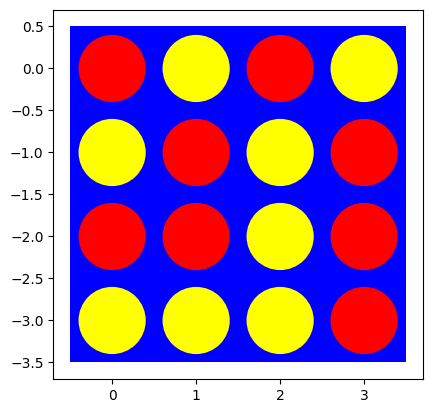

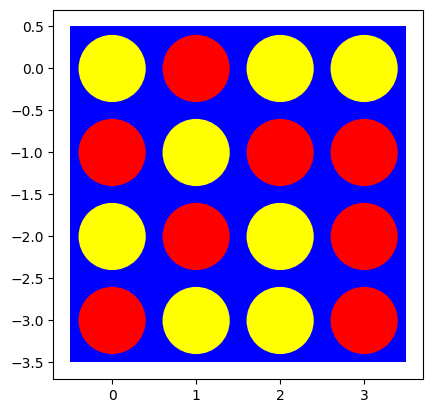

In [8]:
# Your code/ answer goes here.
board1 = [[0,0,0,0],
          [0,0,0,1],
          [0,0,0,1],
          [-1,-1,-1,1]]
board2 = [[0,0,0,-1],
          [-1,1,0,1],
          [1,-1,1,1],
          [-1,-1,-1,1]]
board3 = [[0,0,0,1],
          [0,0,0,1],
          [0,0,1,1],
          [0,-1,-1,-1]]
board4 = [[0,0,0,-1],
          [0,1,0,1],
          [0,1,-1,1],
          [0,-1,-1,1]]
board5 = [[0,0,0,0],
          [0,0,0,1],
          [0,0,0,1],
          [0,-1,-1,1]]
boards = [board1,board2,board3,board4,board5]

# minimax_env(board1,verbose=True)

for theBoard in boards:
    minimax_env(theBoard)


How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

It takes about 45 seconds in a 4x5 board and anything larger than that takes way too long to be practical. This might be due to a poor implementation of my helper functions but either way, I will most likely not be utilizing this type of search for the competition

### Move ordering

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

Using the initial moves function defined below actually made the algorithm take 3x longer to figure out the best 3rd move while just randomly choosing the first 2 moves proved to be much mor efficient. I am actually quite perplexed about why this is the case... It could have to do with placing in the middle causes more possible outcomes for the algorithm to consider because it determines that it can decide to try to win in different ways while random placement has less chance of placing in the middle which 'forces' the agent to look at a smaller win condition.

In [9]:
# Your code/ answer goes here.
def initial_moves(board,player):
    if(np.count_nonzero(board == player,axis=None) == 0 and len(board[0]) % 2 == 0):
        return {"move":0,"value":0}
    elif(np.count_nonzero(board == player,axis=None) == 0 and len(board[0]) % 2 == 1):
        return {"move":int(round(len(board[0]) / 2,0)),'value':0}
    elif(np.count_nonzero(board == player,axis=None) == 1 and len(board[0]) % 2 == 0):
        return {"move":len(board[0]) -1,'value':0}
    elif(np.count_nonzero(board == player,axis=None) == 1 and len(board[0]) % 2 == 1):
        return {'move':random.choice([int(round(len(board[0] / 2),0) - 1), int(round(len(board[0]) / 2,0) + 1)]),'value':0}
    else:
        return random.choice(HelperFunctions.get_valid_moves(board))
        
def minimax_search_optimal_first_move(board,player=None):
    global ITERATIONS
    ITERATIONS = 0
    curr_iters = 0
    if player is None:
        player = HelperFunctions.to_move(board)
    board = np.array(board)
    if(np.count_nonzero(board == player,axis=None) < 2):
        return initial_moves(board,player)
    
    
    value,move = max_value(board,player,alpha=float('-inf'),beta=float('inf'))
    # print(player)
    color = "Red"
    if player == -1: color = "Yellow"
    global DEBUG
    if DEBUG: print(f"Player: {color} | value: {value} | move:{move}")
    return {"move":move,"value":value}




### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

### Solution
I decided to make the Minimax search make the first 2 moves random because it will drastically speed up the search process in an empty board. Without this, the time that it takes to make an arbitrary move is way too long to be practical and since it is playing out all possible moves, it will end up thinking that it can only tie anyway. I first had it make the first 3 moves randomly but quickly realized that it could end up making 3 moves such that it ensures that it will lose (the case where it's opponent plays 3 in a row while the player does not block either side will cause a certain loss)

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [10]:
# Your code/ answer goes here.
def dynamic_env(players,theBoard=None,verbose=False):
    if theBoard is None:
        theBoard= empty_board(shape=(4,5))
    turns = 0
    # print(theBoard)
    while(HelperFunctions.check_win(theBoard) == 0):
        # visualize(theBoard)
        player = players[turns % 2]['player']
        player_move = players[turns % 2]['algo'](theBoard,player=player)
        if(verbose): print(player_move)
        theBoard = HelperFunctions.place(player_move['move'],theBoard,player=player)
        
        if(verbose):
            print(f"Turn #{turns} | algo:{players[turns%2]['algo'].__name__}")
            visualize(theBoard)
        turns +=1
    return {
        "winner":HelperFunctions.check_win(theBoard),
        "turns_taken":turns
    }
        
def dynamic_stats_env(players,num_iters = 5):
    results = []
    times = []
    for i in range(num_iters):
        print(f"Iteration #{i}")
        start = timer()
        results.append(dynamic_env(players))
        # print(results)
        end = timer()
        times.append(end - start)
    print(f"Average time taken per match: {np.mean(times)}")
    print_results(results) 
        
    
            
players = [
    {
        "algo":minimax_search_optimal_first_move,
        "player":1
     },
    {
        "algo":random_player,
        "player":-1
    }
    
]
# Average time taken per match(optimal first): 64.93823623999988
# Average time taken per match: 22.585232500000167
# dynamic_env(players,verbose=True)
# dynamic_stats_env(players)

## Task 4: Heuristic Alpha-Beta Tree Search [3 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

It was implemented in the HelperFunctions class but the basis is similar to how I calculate the winner of a board. I use numpy convolutions to determine if there are 3 of the same color in a row or 2 of the same color in a row. The three in a row case is weighted at 0.5 and the 2 in a row is weighted as 0.25. From there I add up all of the players as well as all of the opponents pairs/triplets where the opponent's weights are multiplied by -1. From there I sum the result and pass it into a modified sigmoid function that bounds it between 1 and negative 1 which allows my agent to determine if a state is good or bad

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [11]:
class Move:
    def __init__(self,action,util):
        self.action = action
        self.util = util
    def __lt__(self,other):
        return self.util < other.util
    def __gt__(self,other):
        return self.util > other.util
    def __le__(self,other):
        return self.util <= other.util
    def __ge__(self,other):
        return self.util >= other.util
def order_actions_on_util(actions,util_func,player,board):
    # theMoves = [Move((action,util_func(HelperFunctions.place(action,board,player),player) for action in actions))]
    theMoves = [(move,util_func(HelperFunctions.place(move,board,player),player)[0] ) for move in actions]
    theMoves.sort(key = lambda x: x[1],reverse=True)
    # print(theMoves)
    return [move[0] for move in theMoves]


# order_actions_on_util(HelperFunctions.get_valid_moves(empty_board()),HelperFunctions.evaluate_board,1,empty_board())

bananna = order_actions_on_util(HelperFunctions.get_valid_moves(empty_board()),HelperFunctions.evaluate_board,1,empty_board())
print(bananna)



[0, 1, 2, 3, 4, 5, 6]


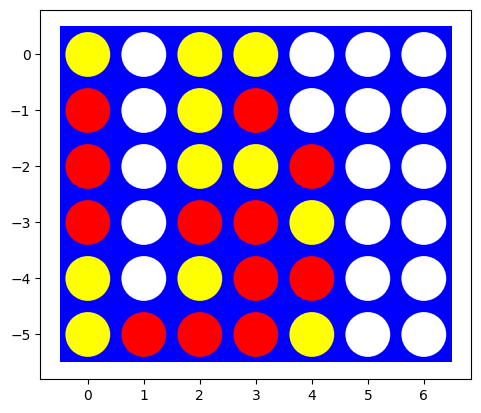

CUTOFF COUNT: 1
CUTOFF COUNT: 2
stopped at 2: [[-1  0 -1 -1  0  0  0]
 [ 1  0 -1  1  0  0  0]
 [ 1  0 -1 -1  1  0  0]
 [ 1  1  1  1 -1  0  0]
 [-1 -1 -1  1  1  0  0]
 [-1  1  1  1 -1  0  0]] term: True eval: -2 [-2, -2]
CUTOFF COUNT: 3
CUTOFF COUNT: 4
stopped at 4: [[-1  0 -1 -1  0  0  0]
 [ 1  0 -1  1  1  0  0]
 [ 1  1 -1 -1  1  0  0]
 [ 1 -1  1  1 -1  0  0]
 [-1 -1 -1  1  1  0  0]
 [-1  1  1  1 -1  0  0]] term: True eval: -2 [-2, -2]
CUTOFF COUNT: 5
CUTOFF COUNT: 6
stopped at 6: [[-1  0 -1 -1  1  0  0]
 [ 1  1 -1  1  1  0  0]
 [ 1 -1 -1 -1  1  0  0]
 [ 1 -1  1  1 -1  0  0]
 [-1 -1 -1  1  1  0  0]
 [-1  1  1  1 -1  0  0]] term: False eval: -0.2449186624037092 [-inf, -2]
CUTOFF COUNT: 7
stopped at 6: [[-1  0 -1 -1  1  0  0]
 [ 1  0 -1  1  1  0  0]
 [ 1 -1 -1 -1  1  0  0]
 [ 1 -1  1  1 -1  0  0]
 [-1 -1 -1  1  1  0  0]
 [-1  1  1  1 -1  0  1]] term: False eval: 0.2449186624037092 [-inf, -2]
CUTOFF COUNT: 8
stopped at 6: [[-1  0 -1 -1  1  0  0]
 [ 1  0 -1  1  1  0  0]
 [ 1 -1 -1 -1  1  0

In [12]:
# Your code/ answer goes here.
from IPython.display import clear_output
import json
CUTOFF_DEBUG = False
CUTOFF_COUNT = 0
def other(the_int):
    if the_int == 1:
        return -1
    else:
        return 1

def a_b_cutoff_search(board,cutoff=None,player=1,verbose=False,eval_func=HelperFunctions.evaluate_board):
    global CUTOFF_DEBUG, CUTOFF_COUNT
    CUTOFF_COUNT = 0
    CUTOFF_DEBUG = verbose
    # print('yeet')
    board = np.array(board)
    # if(np.count_nonzero(board == player,axis=None) < 2):
    #     # print('bad')
    #     return initial_moves(board,player)
    
    value,move = max_value_ab(board,player,-math.inf,+math.inf,0,cutoff,eval_func)
    
    if CUTOFF_DEBUG: print(f"Number of nodes searched (cutoff = {cutoff}): {CUTOFF_COUNT}") 
    
    return {"move": move, "value": value}
def max_value_ab(board,player,alpha,beta,depth,cutoff,eval_func):
    global CUTOFF_DEBUG, CUTOFF_COUNT
    CUTOFF_COUNT+=1
    if(CUTOFF_DEBUG): 
        print(f"CUTOFF COUNT: {CUTOFF_COUNT}")
        # visualize(board)
    v,terminal = eval_func(board,player)
    if((cutoff is not None and depth >= cutoff) or terminal):
        if(terminal):
            alpha,beta = v,v
        if CUTOFF_DEBUG : print(f"stopped at {depth}: {board} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    v, move = -math.inf, None

    actions = []
    try:
        actions = HelperFunctions.get_valid_moves(board)
        random.shuffle(actions)
    except:
        actions = HelperFunctions.get_valid_moves(board)

    actions = order_actions_on_util(actions,eval_func,player,board)
    for action in actions:
        v2,a2 = min_value_ab(HelperFunctions.place(action,board,player=player),player,alpha,beta,depth + 1,cutoff,eval_func)
        if(v2 > v):
            v,move = v2,action
            alpha = max(alpha,v)
        if v >= beta: 
            return v,move
    return v,move

def min_value_ab(board,player,alpha,beta,depth,cutoff,eval_func):
    global CUTOFF_COUNT, CUTOFF_DEBUG
    v,terminal = eval_func(board,player)
    
    if((cutoff is not None and depth >= cutoff) or terminal):
        if terminal:
            alpha,beta = v,v
        if CUTOFF_DEBUG: print(f"stopped at {depth}: {board} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    v,move = +math.inf,None
    
    actions = []
    try:
        actions = HelperFunctions.get_valid_moves(board)
        random.shuffle(actions)
    except:
        actions = HelperFunctions.get_valid_moves(board)
    actions = order_actions_on_util(actions,eval_func,player,board)
    for action in actions:
        v2,a2 = max_value_ab(HelperFunctions.place(action,board,player=other(player)),player,alpha,beta,depth+1,cutoff,eval_func)
        if v2 < v:
            v,move = v2,action
            
            beta = min(beta,v)
        if v <= alpha: 
            return v,move
    return v,move

def truly_dynamic_environment(players,size=(4,4),visual=False,board=None):
    result = {}
    if board is None:
        board = empty_board(shape=size)
    turn_num = 0
    result['algo_info'] = {
        players[0]['algo'].__name__:{'time':[]},
        players[1]['algo'].__name__:{'time':[]}
        }
    result['algo_info']
    past_boards = []
    while(HelperFunctions.check_win(board) == 0): #While there is not a winner yet (0 does not mean draw in this case, it means non terminal state)
        player_turn = turn_num % 2
        
        start = timer()
        choice = players[player_turn]['algo'](board,**players[player_turn]['args'])['move']
        end = timer()
        board = HelperFunctions.place(choice,board,player=players[player_turn]['player'])
        if visual: 
            print(f"Utility for {players[player_turn]['algo'].__name__}: {HelperFunctions.evaluate_board(board,player=player_turn)}")
            visualize(board)
            clear_output(wait=True)
        result['algo_info'][players[player_turn]['algo'].__name__]['time'].append((end - start) * 1000)
        past_boards.append(board)
        turn_num += 1
    result['winner'] = HelperFunctions.check_win(board)
    result['turns_taken'] = turn_num
    
    return result,board,past_boards
        
        
    
# def test(a, b, c = 5):
#     print(a + b + c)
    
# def test_2():
#     print(5)

playerz = [
    {
        "algo":a_b_cutoff_search,
        "player":1,
        "args":{
            'cutoff':5,
            'verbose':False
        }
    },
    {
        "algo":random_player,
        "player":-1,
        "args":{}
    }
]

# result,final_board,board_states = truly_dynamic_environment(playerz,size=(6,7))

board = [
    [-1,  0, -1, -1,  0,  0,  0],
    [ 1,  0, -1,  1,  0,  0,  0,],
    [ 1,  0, -1, -1,  1,  0,  0,],
    [ 1,  0,  1,  1, -1,  0,  0],
    [-1,  0, -1,  1,  1, 0,  0],
    [-1,  1,  1,  1, -1,  0,  0]

]
visualize(board)

print(a_b_cutoff_search(board,cutoff=6,player=-1,verbose=True))
# print(json.dumps(result, indent=4, sort_keys=True))
# board = [[-1,0,0,0,0,0],
#          [1,0,0,0,0,0],
#          [1,0,0,0,0,1],
#          [1,1,-1,1,-1,1]]
# print(result)
# print(HelperFunctions.place(0,board,1))
   
    
# print(a_b_cutoff_search(board,verbose=True,cutoff=5))
    
    


Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

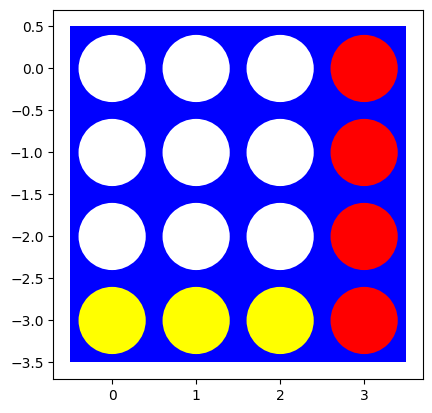

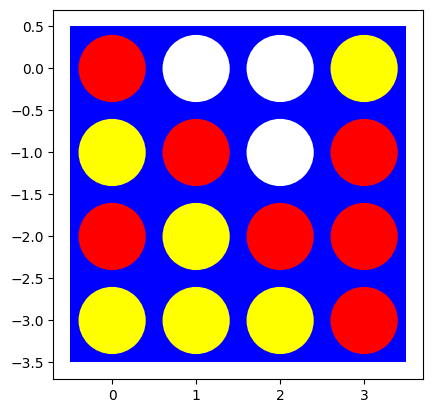

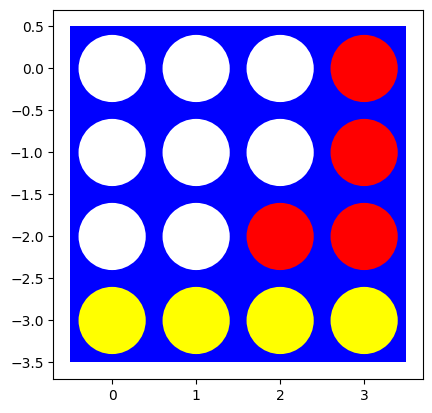

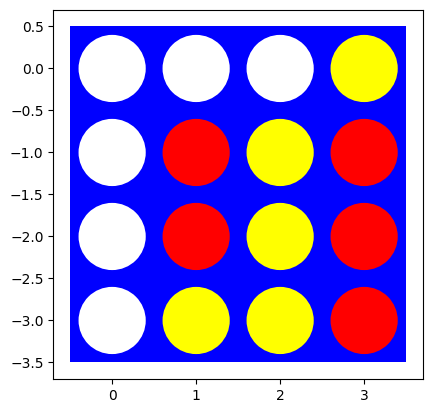

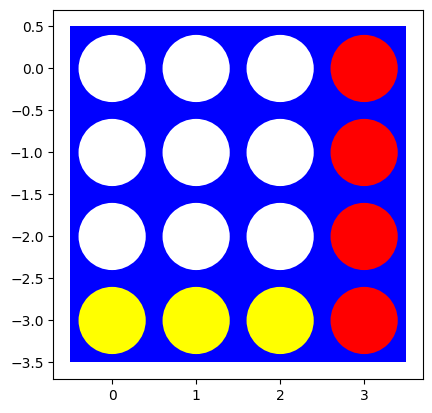

In [13]:
# Your code/ answer goes here.
board1 = [[0,0,0,0],
          [0,0,0,1],
          [0,0,0,1],
          [-1,-1,-1,1]]
board2 = [[0,0,0,-1],
          [-1,1,0,1],
          [1,-1,1,1],
          [-1,-1,-1,1]]
board3 = [[0,0,0,1],
          [0,0,0,1],
          [0,0,1,1],
          [0,-1,-1,-1]]
board4 = [[0,0,0,-1],
          [0,1,0,1],
          [0,1,-1,1],
          [0,-1,-1,1]]
board5 = [[0,0,0,0],
          [0,0,0,1],
          [0,0,0,1],
          [-1,-1,-1,1]]
boards = [board1,board2,board3,board4,board5]

# minimax_env(board1,verbose=True)

for theBoard in boards:
    visualize(HelperFunctions.place(a_b_cutoff_search(theBoard)['move'],theBoard))

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [14]:
# Your code/ answer goes here.
result = truly_dynamic_environment(playerz,size=(6,7))

def board_stepper(playerz,sizes):
    results = {}
    for currSize in sizes:
        results[str(currSize)] = (truly_dynamic_environment(playerz,size=currSize))
    return results

def board_stepper_results(results):
    print('|Algorithm|Average decision time|')
    print('|---------|---------------------|')
    for key in results:
        curr_iter = results[key]
        for name in curr_iter['algo_info']:
            theString = "|" + name + '|' + str(np.average(curr_iter[name]['time']))
            print(theString)
                



# _result = board_stepper(playerz=playerz,sizes=sizes)


# print(json.dumps(result, indent=4, sort_keys=True))

### Computation times for a cutoff = 5

|Board Size|Time to compute|
|------|----|
|4x4|20.18|
|4x5|110.72|
|4x6|109.12|
|4x7|367.05|
|5x7|112.4|
|6x7|157.6|

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [15]:
# Your code/ answer goes here.

playerz = [
    {
        "algo":a_b_cutoff_search,
        "player":1,
        "args":{
            'cutoff':7,
            'verbose':False
        }
    },
    {
        "algo":a_b_cutoff_search,
        "player":-1,
        "args":{
            'cutoff':3,
            'verbose':False
        }
    }
]

# result,final_board,all_boards = truly_dynamic_environment(playerz,size=(6,7),visual=True)

# visualize(final_board)
# print(json.dumps(result, indent=4, sort_keys=True))



## Challenge task [+ 1 bonus point]

Find another student and let your best agent play against the other student's best player. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search and investigate how this search performs on the test boards that you have used above. 

(0.35835739835078595, False)


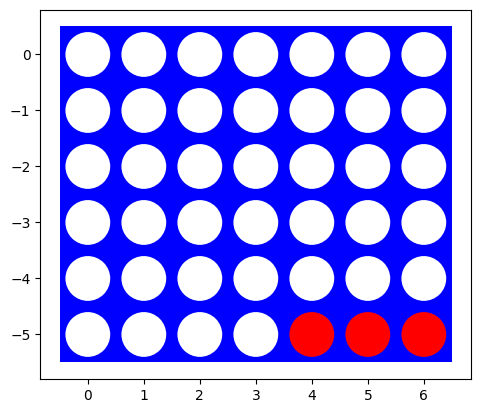


        Move Values: [0.35835739835078595, 0.4621171572600098, 0.5545997223493822, 2, 0.5545997223493822, 0.5545997223493822, 0.4621171572600098]
        Normalized Values: [0.08310633 0.09219267 0.10112559 0.42913155 0.10112559 0.10112559
 0.09219267]
        Sum of Normalized vals: 1.0000000000000002
        
{'move': 4}


In [16]:
# Your code/ answer goes here.
from scipy.special import softmax
def heuristic_random_player(state,player=1,verbose=False):
    actions = HelperFunctions.get_valid_moves(state)
    move_value = []
    for move in actions:

        tmp_state = HelperFunctions.place(move,state,player = player)
        util_val = HelperFunctions.evaluate_board(tmp_state,player)[0]
        if util_val == 1:
            return {"move":move}
        move_value.append(util_val)
    
    # move_value2 = [val + np.quantile(move_value, .25) for val in move_value]
    if verbose:
        print(f"""
        Move Values: {move_value}
        Normalized Values: {softmax(move_value)}
        Sum of Normalized vals: {np.sum(softmax(move_value))}
        """)
    return {"move":random.choices(actions, weights=list(softmax(move_value)))[0]}

    


def playout(state, action, player = 1,cutoff_val = 3,playout_func=random_player):
    
    state = HelperFunctions.place(action,state,player=player)
    current_player = other(player)
    
    while(True):
        # reached terminal state?
        try:
            return HelperFunctions.calc_utility(player,state)
        except:
            action= playout_func(state,player=current_player)['move']
            state = HelperFunctions.place(action,state,player=current_player)
            
            current_player = other(current_player)
            
            
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 1, 1]]


print(HelperFunctions.evaluate_board(board,player=1))
visualize(board)
print(heuristic_random_player(board,verbose=True))
# board = empty_board()

# for i,val in enumerate(board):
#     print(playout(board,i,cutoff_val=2))

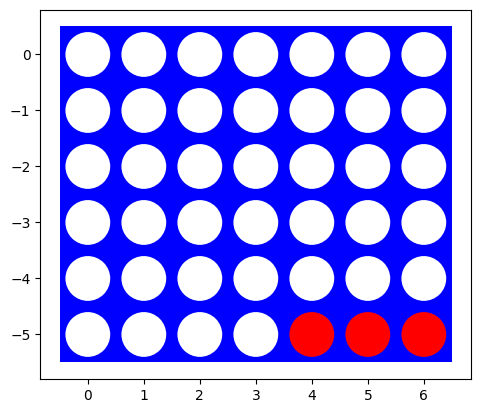

Playout results: [1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, -1, 1, 1, 1, -1]
mean utility: 0.54
win probability: 0.77
loss probability: 0.23
draw probability: 0.0


In [17]:
def playouts(board,action, player=1,N=100,playout_func=random_player):
    return [playout(board,action,player,cutoff_val=2,playout_func=playout_func) for i in range(N)]


visualize(board)
u = playouts(board, 0)
print("Playout results:", u)

print(f"mean utility: {np.mean(u)}")

p_win = sum(np.array(u) == +1)/len(u)
p_loss = sum(np.array(u) == -1)/len(u)
p_draw = sum(np.array(u) == 0)/len(u)
print(f"win probability: {p_win}")
print(f"loss probability: {p_loss}")
print(f"draw probability: {p_draw}")

In [18]:
DEBUG = True
def pmcs(board,N=50,player=1,verbose=False,playout_func=random_player):
    global DEBUG
    DEBUG = verbose
    acts = HelperFunctions.get_valid_moves(board)
    n = math.floor(N/len(acts))
    if DEBUG: print(f"Actions: {acts} ({n} playouts per action)")
    ps = { i : np.mean(playouts(board, i, player, N = n,playout_func=playout_func)) for i in acts }
    if DEBUG: display(ps)
    action = max(ps, key=ps.get)
    
    return {"move":action}

# board = [[0, 0, 0, 0, 0, 0, 0],
#          [0, 0, 0, 0, 0, 0, 0],
#          [0, 0, 0, 0, 0, 0, 0],
#          [0, 0, 0, 0, 0, 0, 0],
#          [0, 0, 0, 0, 0, 1, 1],
#          [0, 0, 0, -1, -1, -1, 1]]
# visualize(board)
# print(pmcs(board,verbose=True,N=100))
# print(pmcs(board,verbose=True,playout_func=heuristic_random_player,N=100))

### Pure-Monte-Carlo VS. Heuristic Alpha Beta Pruining


In [19]:
playerz = [
    {
        "algo":pmcs,
        "player":1,
        "args":{
            'N':2000,
            'verbose':False,
            'player':1
        }
    },
    {
        "algo":a_b_cutoff_search,
        "player":-1,
        "args":{
            'verbose':False,
            'cutoff':6,
            'player':-1
        }
    }
]

# result,final_board,past_boards = truly_dynamic_environment(playerz,size=(6,7),visual=True)

# test_board = [
#     [0,0,0,0,0,0,0],
#     [0,0,0,0,0,0,0],
#     [0,0,0,0,0,0,0],
#     [0,0,-1,-1,0,0,0],
#     [0,0,1,1,1,0,0],
#     [0,0,-1,1,-1,1,0]
# ]

# visualize(final_board)
# visualize(past_boards[len(past_boards) - 3])
# print(past_boards[len(past_boards) - 3])
# print(a_b_cutoff_search(test_board,8,-1))
# print(json.dumps(result, indent=4, sort_keys=True))

### Best First Move

How would you determine what the best first move is? You can use Pure Monte Carlo Search or any algorithms 
that you have implemented above.

In [20]:
from IPython.display import clear_output
def interractive_game(algo,args):
    board = empty_board()
    turn_num = 0
    players = [-1,1]
    diff = int(input("What do you want the difficulty to be? (Integer value): "))
    if algo.__name__ == 'a_b_cutoff_search':
        args['cutoff'] = diff
    while(HelperFunctions.check_win(board) == 0):
        visualize(board)
        player_turn = turn_num % 2
        if(player_turn == 1):
            choice =algo(board=board,**args)['move']
        else:
            choice = int(input('Enter a number to place a tile'))
            
        board = HelperFunctions.place(choice,board,player=players[player_turn % 2])
        
        
        turn_num += 1
        clear_output()
    visualize(board)

args = {
    'cutoff':7,
}


# interractive_game(a_b_cutoff_search,args)

In [21]:
# Your code/ answer goes here.
def find_best_start():
    # moves = []
    for i in range(7):
        u = playouts(board, i,N=1000)
        

        print(f"mean utility of {i}: {np.mean(u)}")

        # p_win = sum(np.array(u) == +1)/len(u)
        # p_loss = sum(np.array(u) == -1)/len(u)
        # p_draw = sum(np.array(u) == 0)/len(u)
        # print(f"win probability: {p_win}")
        # print(f"loss probability: {p_loss}")
        # print(f"draw probability: {p_draw}")
        
find_best_start()

mean utility of 0: 0.619
mean utility of 1: 0.588
mean utility of 2: 0.577
mean utility of 3: 1.0
mean utility of 4: 0.642
mean utility of 5: 0.623
mean utility of 6: 0.599


### Result
It appears that if the first player places at index 2, they have the highest odds of winning

Winrate of my best agent

In [22]:
playerz = [
    {
        "algo":a_b_cutoff_search,
        "player":1,
        "args":{
            'verbose':False,
            'cutoff':7,
            'player':1
        }
    },
    {
        "algo":pmcs,
        "player":-1,
        "args":{
            'N':3400,
            'verbose':False,
            'player':-1
        }
    }
]

def winrate_calculator(players,iterations=10,visual=False):
    winners = []
    for i in range(iterations):
        print(f"Currently playing game #{i}")
        result,final_board,past_boards = truly_dynamic_environment(players,size=(6,7),visual=visual)
        winners.append(result['winner'])
        for algo in result['algo_info']:
            print(f"{algo} Took {round(np.sum(result['algo_info'][algo]['time'])/1000)} s")
    ties = [val for val in winners if val is None]
    print(f"{len(ties)} ties happened")
    _winners = [val for val in winners if val is not None]

    print(f"Average of winners: {np.mean(_winners)}")
    

# winrate_calculator(players=playerz,iterations=25)



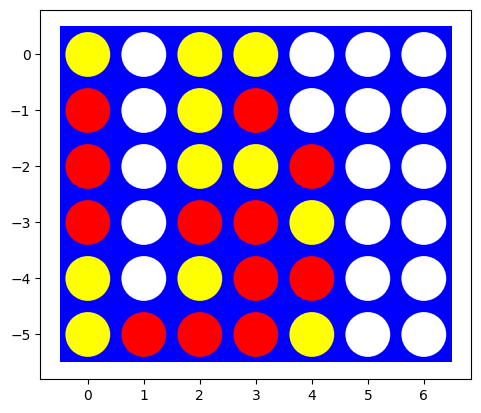

(-0.4621171572600098, False)


In [23]:

board = [
    [-1,  0, -1, -1,  0,  0,  0],
    [ 1,  0, -1,  1,  0,  0,  0,],
    [ 1,  0, -1, -1,  1,  0,  0,],
    [ 1,  0,  1,  1, -1,  0,  0],
    [-1,  0, -1,  1,  1, 0,  0],
    [-1,  1,  1,  1, -1,  0,  0]

]
visualize(board)
print(HelperFunctions.evaluate_board(board,-1))



In [24]:
# Custom Exception for move handling
class MoveException(Exception):
    def __init__(self, move, *args):
        super(MoveException, self).__init__(move, *args)
        self.move = move

def test():
    raise MoveException(5)
try:
    test()
except MoveException as mv:
    print(mv.move)


5


In [25]:

import threading
import multiprocess
from multiprocessing.dummy import Pool as ThreadPool

def threaded_util_calc(move,state,player):
    tmp_state = HelperFunctions.place(move,state,player = player)
    util_val = HelperFunctions.evaluate_board(tmp_state,player)[0]
    if util_val == 1:
        raise MoveException(move)
    return util_val

def heuristic_random_player_threaded(state,player=1,verbose=False):
    actions = HelperFunctions.get_valid_moves(state)
    items = [(act,state,player) for act in actions]
    move_value = []

    try:
        with ThreadPool(len(items)) as pool:
            test = pool.starmap(threaded_util_calc,items)
            move_value = test
            # print(move_value)
    except MoveException as mv:
        return {"move":mv.move}
    # for move in actions:

    #     tmp_state = HelperFunctions.place(move,state,player = player)
    #     util_val = HelperFunctions.evaluate_board(tmp_state,player)[0]
    #     if util_val == 1:
    #         return {"move":move}
    #     move_value.append(util_val)
    
    # move_value2 = [val + np.quantile(move_value, .25) for val in move_value]
    if verbose:
        print(f"""
        Move Values: {move_value}
        Normalized Values: {softmax(move_value)}
        Sum of Normalized vals: {np.sum(softmax(move_value))}
        """)
    return {"move":random.choices(actions, weights=list(softmax(move_value)))[0]}

def threaded_playout(state, action, player,playout_func):
    
    state = HelperFunctions.place(action,state,player=player)
    current_player = other(player)
    
    while(True):
        # reached terminal state?
        try:
            return HelperFunctions.calc_utility(player,state)
        except:
            action= playout_func(state,player=current_player)['move']
            state = HelperFunctions.place(action,state,player=current_player)
            
            current_player = other(current_player)

def threaded_playouts(board,action, player,N,shared_data,playout_func):
    return {action:[threaded_playout(board,action,player,playout_func) for i in range(N)]}

def multi_threaded_pmcs(board,N=50,player=1,verbose=False,playout_func=random_player):
    global DEBUG
    DEBUG = verbose
    acts = HelperFunctions.get_valid_moves(board)
    n = math.floor(N/len(acts))

    if DEBUG: print(f"Actions: {acts} ({n} playouts per action)")
    # i : np.mean(playouts(board, i, player, N = n,playout_func=playout_func)) for i in acts 

    ps = {i:[] for i in acts }
    items = []
    for i in acts:
        items.append((board,i,player,n,ps,playout_func))

    with multiprocess.Pool() as pool:
        test = pool.starmap(threaded_playouts,items)
        for item in test:
            for j_title in item:
                ps[j_title] = np.mean(item[j_title])
        
        if DEBUG: display(ps)
        

    action = max(ps, key=ps.get)
        
        
    return {"move":action}



    
    

    
    

In [26]:
playerz = [
    {
        "algo":a_b_cutoff_search,
        "player":1,
        "args":{
            'verbose':False,
            'cutoff':7,
            'player':1,
            
        }
    },
    {
        "algo":pmcs,
        "player":-1,
        "args":{
            'N':3600,
            'verbose':False,
            'player':-1,
            'playout_func':random_player
        }
    }
]


#TODO Test monte carlo with N= 10000 vs a_b with cutoff = 7
# result,a,b =  truly_dynamic_environment(playerz,size=(6,7),visual=True)

# visualize(a)
# visualize(b[len(b) - 3])
# print(b[len(b) - 3])
# winrate_calculator(players=playerz,iterations=25)

In [27]:
def monte_carlo_eval(board,player):
    try:
        return HelperFunctions.calc_utility(player),True
    except:

        acts = HelperFunctions.get_valid_moves(board)
        n = math.floor(1000/len(acts))

        # if DEBUG: print(f"Actions: {acts} ({n} playouts per action)")
        # i : np.mean(playouts(board, i, player, N = n,playout_func=playout_func)) for i in acts 

        ps = {i:[] for i in acts }
        items = []
        for i in acts:
            items.append((board,i,player,n,ps,random_player))

        with multiprocess.Pool() as pool:
            test = pool.starmap(threaded_playouts,items)
            for item in test:
                for j_title in item:
                    ps[j_title] = np.mean(item[j_title])
            
            # if DEBUG: display(ps)
            

        return np.mean([ps[yes] for yes in ps]),False
    
        
        
    print(ps)



# visualize(b)
# tmp = b[len(b) -3]
# visualize(tmp)
# monte_carlo_eval(empty_board(),1)
# tmp = HelperFunctions.place(1,tmp,1)

# c,d,e =truly_dynamic_environment(playerz,visual=True,board=tmp)

# visualize(d)
# visualize(e[len(e) - 3])
# visualize(tmp)
# print(multi_threaded_pmcs(b[len(b) - 3],10000,1,verbose=True))
# print(pmcs(b[len(b) - 3],3600,1,verbose=True))
# print(a_b_cutoff_search(b[len(b) - 3],cutoff=500,player=1,verbose=False))
#TODO Make it a 40% chance to do random 
# print(threaded_playouts(board,))


In [28]:
playerz = [
    {
        "algo":a_b_cutoff_search,
        "player":1,
        "args":{
            'verbose':False,
            'cutoff':3,
            'player':1,
            'eval_func':monte_carlo_eval
            
        }
    },
    {
        "algo":a_b_cutoff_search,
        "player":-1,
        "args":{
            'cutoff':7,
            'verbose':False,
            'player':-1,
        }
    }
]

board = [
    [-1,  0, -1, -1,  0,  0,  0],
    [ 1,  0, -1,  1,  0,  0,  0,],
    [ 1,  0, -1, -1,  1,  0,  0,],
    [ 1,  0,  1,  1, -1,  0,  0],
    [-1,  0, -1,  1,  1, 0,  0],
    [-1,  1,  1,  1, -1,  0,  0]

]

# visualize(board)
# #TODO Test monte carlo with N= 10000 vs a_b with cutoff = 7
# result,a,b =  truly_dynamic_environment(playerz,size=(6,7),visual=True)

# # print(a_b_cutoff_search(board,cutoff=3,player=1,eval_func=monte_carlo_eval))

# visualize(a)
# visualize(b[len(b) - 3])
# print(b[len(b) - 3])

In [29]:
from environment import truly_dynamic_environment,replay
from shockley_agents import shock_and_awe
playerz = [
    {
        "algo":shock_and_awe,
        "player":1,
        "args":{
            
        }
    },
    {
        "algo":a_b_cutoff_search,
        "player":-1,
        "args":{
            "cutoff":8,
            "player":-1
        }
    }
]

# print(shock_and_awe(empty_board()))


# result,final_board,all_boards = truly_dynamic_environment(playerz,size=(6,7),visual=True)

# # replay(all_boards)
# visualize(final_board)

In [30]:
from IPython.display import clear_output
from shockley_agents import a_b_cutoff_search_random
def interractive_game(algo,args):
    board = empty_board()
    # board = [
    # [-1,  0, -1, -1,  0,  0,  0],
    # [ 1,  0, -1,  1,  0,  0,  0,],
    # [ 1,  0, -1, -1,  1,  0,  0,],
    # [ 1,  0,  1,  1, -1,  0,  0],
    # [-1,  0, -1,  1,  1, 0,  0],
    # [-1,  1,  1,  1, -1,  0,  0]

    # ]
    turn_num = 0
    players = [-1,1]
    diff = int(input("What do you want the difficulty to be? (Integer value): "))
    if algo.__name__ == 'a_b_cutoff_search':
        args['cutoff'] = diff
    while(HelperFunctions.check_win(board) == 0):
        visualize(board)
        player_turn = turn_num % 2
        if(player_turn == 1):
            choice =algo(board=board,**args)['move']
        else:
            choice = int(input('Enter a number to place a tile'))
            
        board = HelperFunctions.place(choice,board,player=players[player_turn % 2])
        
        
        turn_num += 1
        clear_output()
    visualize(board)

# interractive_game(shock_and_awe,args={})


In [32]:
playerz = [
    {
        "algo":shock_and_awe,
        "player":1,
        "args":{
            
        }
    },
    {
        "algo":multi_threaded_pmcs,
        "player":-1,
        "args":{
            "N":100000,
            "player":-1
        }
    }
]
winrate_calculator(players=playerz,iterations=5,visual=True)

shock_and_awe Took a total of: 55.52 seconds
multi_threaded_pmcs Took a total of: 114.93 seconds
shock_and_awe Took 56 s
multi_threaded_pmcs Took 115 s
1 ties happened
Average of winners: 1.0
